<h1 style="text-align: center;">Stuff+ Model</h1>

## Loading Libraries

In [114]:
## pyb stuff
import pybaseball as pyb
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

import pandas as pd 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## added yesterday's date so the data we get is updated everytime the statcast data cell is ran
from datetime import date, timedelta, datetime
today = date.today()
yesterday = today - timedelta(days=1)
formatted_date = yesterday.strftime("%Y-%m-%d")

## ML stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import root_mean_squared_error
scaler = StandardScaler()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import shap

## linear model
from pygam import LinearGAM, s, f


import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
def clean_metric(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    imputes the missing data within the columns with the average of each pitcher's pitch

    Arguments: df: the df that has the uncleaned cols, l: the metric to be cleaned
    """
    df = df.copy()
    df[col] = df[col].fillna(df.groupby(['pitcher', 'pitch_type'])[col].transform('mean'))
    return df

In [3]:
def catch_made_hist(df: pd.DataFrame, column: str, ax=None) -> None:
    """
    Displays overlapping histograms between successful catches and not for some column
    
    Arguments: column: is some quantitative column in df
    """
    df = df.copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        
    ax.hist(df[df['is_csw'] == 0][column], bins=25, alpha=0.7, label='CSW == 0', color='#CC3433', density=True)
    ax.hist(df[df['is_csw'] == 1][column], bins=25, alpha=0.7, label='CSW == 1', color='#89CFF0', density=True)
    ax.set_xlabel(column.replace('_', ' '))
    ax.set_ylabel('Density')
    ax.set_title(f"{column.replace('_', ' ')} Histograms\n Comparisons")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

## Loading in the Data

In [4]:
## the code below to run the data takes like 5 1/2 min to run but we get 4 years worth of data
start_date = '2023-03-01'
end_date = formatted_date

## gets rid of 08/18/24 --> it's coming as an error on my end for some reason
statcast_data_p1 = pyb.statcast(start_date, '2024-08-17')
statcast_data_p2 = pyb.statcast('2024-08-19', '2025-07-15')

statcast_data = pd.concat([statcast_data_p1, statcast_data_p2]).sort_values(by='game_date').reset_index(drop=True)
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True) ## gets rid of the null pitches
statcast_data.head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 402/402 [02:17<00:00,  2.92it/s]


This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 212/212 [00:52<00:00,  4.01it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,ST,2023-03-15,79.4,-2.93,4.6,"Gomez, Carlos",656555,680622,walk,ball,<NA>,<NA>,<NA>,<NA>,11,Rhys Hoskins walks.,S,R,R,NYY,PHI,B,<NA>,NaN,3,2,2023,1.59,0.7,-1.43,3.05,<NA>,669016,<NA>,2,1,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.322407,-115.740639,1.98078,14.304629,19.561541,-26.405332,3.58,1.67,<NA>,<NA>,<NA>,79.4,2576,6.0,719116,660710,641343,665828,643396,683011,664314,542364,592450,54.53,<NA>,<NA>,0.7,<NA>,0,0,<NA>,11,6,Sweeper,0,7,7,0,7,0,7,0,Standard,Standard,78,-0.002,0.162,<NA>,<NA>,<NA>,-0.162,<NA>,-7,7,0.052,0.948,25,30,25,30,1,1,<NA>,<NA>,<NA>,<NA>,2.88,-1.59,-1.59,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,FF,2023-03-15,90.8,-2.66,5.95,"Gausman, Kevin",675986,592332,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,7,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,0,2023,-0.9,1.48,-0.63,1.87,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6.983639,-131.715447,-7.311041,-12.06585,33.696973,-13.604343,3.37,1.53,<NA>,<NA>,<NA>,89.9,1535,6.4,719109,672386,665489,593160,669289,666182,662139,664770,624415,54.13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,1,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,150,0.0,-0.042,<NA>,<NA>,<NA>,0.042,<NA>,2,-2,0.738,0.262,32,24,32,24,2,1,<NA>,<NA>,<NA>,<NA>,1.35,0.9,-0.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,FF,2023-03-15,92.8,-2.59,5.92,"Gausman, Kevin",675986,592332,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,8,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,1,2023,-0.91,1.36,0.12,1.88,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.923854,-134.560656,-7.389989,-13.158533,34.192646,-14.20309,3.37,1.53,<NA>,<NA>,<NA>,92.2,2332,6.5,719109,672386,665489,593160,669289,666182,662139,664770,624415,53.98,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,2,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,213,0.0,-0.054,<NA>,<NA>,<NA>,0.054,<NA>,2,-2,0.738,0.262,32,24,32,24,2,1,<NA>,<NA>,<NA>,<NA>,1.35,0.91,-0.91,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,FF,2023-03-15,93.3,-2.57,5.85,"Gausman, Kevin",675986,592332,NaN,foul,<NA>,<NA>,<NA>,<NA>,8,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,2,2023,-0.85,1.29,0.05,1.71,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.626394,-135.314719,-7.644525,-12.491483,33.261627,-14.727936,3.37,1.53,2,75.7,-36,92.8,2053,6.5,719109,672386,665489,593160,669289,666182,662139,664770,624415,54.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,3,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,168,0.0,0.0,<N

In [5]:
## preparing the data
important_stuff_cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'pitcher',
                        'events', 'description', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'on_3b', 'on_2b', 'on_1b',
                        'outs_when_up', 'release_spin_rate', 'release_extension', 'pitch_name', 'spin_axis',
                        'delta_pitcher_run_exp', 'stand', 'zone']

statcast_data_cleaned = statcast_data[important_stuff_cols].copy()
statcast_data_cleaned['on_1b'] = statcast_data_cleaned['on_1b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_2b'] = statcast_data_cleaned['on_2b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_3b'] = statcast_data_cleaned['on_3b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned[['pfx_x', 'pfx_z']] = statcast_data_cleaned[['pfx_x', 'pfx_z']] * 12
misc_pitches = ['Eephus', 'Pitch Out', 'Slow Curve', 'Knuckleball', 'Forkball', 'Screwball', 'Slurve', 'Knuckle Curve', 'Other']
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['pitch_name'].isin(misc_pitches)].reset_index(drop=True).copy()

## cleans the delta_pitcher_run_exp by giving it the proper run expectancy change
statcast_data_cleaned.loc[616354, 'delta_pitcher_run_exp'] = -0.115
statcast_data_cleaned.loc[616355, 'delta_pitcher_run_exp'] = 0.298

## makes sure spin rate is a float
statcast_data_cleaned['release_spin_rate'] = pd.to_numeric(statcast_data_cleaned['release_spin_rate'], errors='coerce').astype(float)
## makes sure spin axis is a float
statcast_data_cleaned['spin_axis'] = pd.to_numeric(statcast_data_cleaned['spin_axis'], errors='coerce').astype(float)

## encoding the binary variables
statcast_data_cleaned['p_throws'] = statcast_data_cleaned['p_throws'].apply(lambda x: x=='R').astype(int)
statcast_data_cleaned['stand'] = statcast_data_cleaned['stand'].apply(lambda x: x=='R').astype(int)

statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_speed')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_spin_rate')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_extension')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'spin_axis')

## gets rid of the plays that had missing values for each pitch metric
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['release_spin_rate'].isna()].reset_index(drop=True).copy()

statcast_data_cleaned['is_csw'] = statcast_data_cleaned['description'].apply(lambda x: x in ['called_strike', 'swinging_strike', 'swinging_strike_blocked']).astype(int)
statcast_data_cleaned = statcast_data_cleaned.rename(columns={'pfx_x': 'horz_break', 
                                                              'pfx_z': 'induced_vert_break',
                                                              'release_pos_x': 'rel_side',
                                                              'release_pos_z': 'rel_height',
                                                              'release_spin_rate': 'spin_rate',
                                                              'release_extension': 'extension'
                                                              }).copy()

In [6]:
## mirror handedness metrics
statcast_data_cleaned['rel_side'] *= -1
statcast_data_cleaned['horz_break'] *= -1
statcast_data_cleaned = statcast_data_cleaned.drop(columns = ['p_throws']).copy()

statcast_data_cleaned.head()

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,ST,79.4,2.93,4.6,"Gomez, Carlos",680622,walk,ball,3,2,-19.08,8.4,0,1,0,2,2576.0,6.0,Sweeper,78.0,-0.162,1,11,0
1,FF,90.8,2.66,5.95,"Gausman, Kevin",592332,NaN,called_strike,0,0,10.8,17.76,0,0,0,0,1535.0,6.4,4-Seam Fastball,150.0,0.042,0,7,1
2,FF,92.8,2.59,5.92,"Gausman, Kevin",592332,NaN,called_strike,0,1,10.92,16.32,0,0,0,0,2332.0,6.5,4-Seam Fastball,213.0,0.054,0,8,1
3,FF,93.3,2.57,5.85,"Gausman, Kevin",592332,NaN,foul,0,2,10.2,15.48,0,0,0,0,2053.0,6.5,4-Seam Fastball,168.0,0.0,0,8,0
4,FF,94.8,2.59,5.78,"Gausman, Kevin",592332,field_out,hit_into_play,0,2,12.0,13.32,0,0,0,0,2304.0,6.6,4-Seam Fastball,140.0,0.169,0,13,0


### EDA

In [9]:
X = statcast_data_cleaned[['delta_pitcher_run_exp', 'release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height', 'pitch_type']].copy()
cols_to_standardize = ['release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height']
X[cols_to_standardize] = (X.groupby('pitch_type')[cols_to_standardize].transform(lambda x: (x - x.mean()) / x.std()))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type
0,-0.162,-0.835526,0.040916,-0.929637,1.615153,-0.414518,-0.859231,0.937351,-1.595313,ST
1,0.042,-1.40067,-4.586144,0.934089,0.681419,-1.344397,-0.255967,1.012627,0.265956,FF
2,0.054,-0.592846,0.222533,0.949189,0.189938,0.534362,-0.03005,0.974056,0.203021,FF
3,0.0,-0.390891,-1.460806,0.858591,-0.096759,-0.807608,-0.03005,0.963036,0.056174,FF
4,0.169,0.214977,0.053596,1.085087,-0.83398,-1.642612,0.195868,0.974056,-0.090674,FF
...,...,...,...,...,...,...,...,...,...,...
1891251,-0.045,1.242344,-1.143795,-1.847152,-1.247267,-3.664472,2.51233,-1.290744,0.760544,FS
1891252,0.223,1.830623,0.475939,-0.772183,1.500553,-0.956716,1.777292,-0.397977,0.664543,FF
1891253,-0.041,2.280573,1.590208,-1.203426,1.823238,-0.601996,1.900266,-0.420885,0.822587,SI
1891254,0.233,0.825638,-0.868019,0.892408,2.472615,1.596977,1.706754,-0.534523,0.560866,SL


In [10]:
import statsmodels.formula.api as smf

#cleaning
X = X.replace({pd.NA: np.nan})
X = X.astype({col: float for col in ["release_speed", "spin_rate", 
                                     "horz_break", "induced_vert_break", 
                                     "spin_axis", "extension", 
                                     "rel_side", "rel_height"]})
X = X.dropna(subset=["delta_pitcher_run_exp", "release_speed", "spin_rate",
                     "horz_break", "induced_vert_break", "spin_axis", 
                     "extension", "rel_side", "rel_height"])

model = smf.mixedlm("delta_pitcher_run_exp ~ release_speed + spin_rate + horz_break + induced_vert_break + spin_axis + extension + rel_side + rel_height", 
                    data=X, groups=X["pitch_type"]).fit()
print(model.summary())

y_pred = model.predict(X)
y_pred

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: delta_pitcher_run_exp
No. Observations: 1891236  Method:             REML                 
No. Groups:       8        Scale:              0.0508               
Min. group size:  54947    Log-Likelihood:     134036.7398          
Max. group size:  621486   Converged:          Yes                  
Mean group size:  236404.5                                          
---------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept              0.000     0.080   0.004  0.997  -0.156   0.156
release_speed          0.002     0.000  13.677  0.000   0.002   0.003
spin_rate              0.002     0.000  11.331  0.000   0.002   0.002
horz_break            -0.001     0.000  -2.316  0.021  -0.001  -0.000
induced_vert_break     0.001     0.000   3.

0         -0.001803
1         -0.015053
2         -0.001913
3         -0.006018
4         -0.002696
             ...   
1891251    0.002039
1891252    0.008182
1891253    0.012335
1891254    0.005143
1891255    0.003971
Length: 1891236, dtype: float64

In [11]:
X['run_value'] = y_pred
X['stuff'] = X.groupby('pitch_type')['run_value'].transform(lambda x: ((x - x.mean()) / x.std()))

In [12]:
X['stuff+'] = X['stuff'].apply(lambda x: 100 + (10*x))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type,run_value,stuff,stuff+
0,-0.162,-0.835526,0.040916,-0.929637,1.615153,-0.414518,-0.859231,0.937351,-1.595313,ST,-0.001803,-0.635877,93.641235
1,0.042,-1.400670,-4.586144,0.934089,0.681419,-1.344397,-0.255967,1.012627,0.265956,FF,-0.015053,-4.142355,58.576445
2,0.054,-0.592846,0.222533,0.949189,0.189938,0.534362,-0.030050,0.974056,0.203021,FF,-0.001913,-0.598307,94.016935
3,0.0,-0.390891,-1.460806,0.858591,-0.096759,-0.807608,-0.030050,0.963036,0.056174,FF,-0.006018,-1.705455,82.945455
4,0.169,0.214977,0.053596,1.085087,-0.833980,-1.642612,0.195868,0.974056,-0.090674,FF,-0.002696,-0.809443,91.905568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891251,-0.045,1.242344,-1.143795,-1.847152,-1.247267,-3.664472,2.512330,-1.290744,0.760544,FS,0.002039,0.500909,105.009089
1891252,0.223,1.830623,0.475939,-0.772183,1.500553,-0.956716,1.777292,-0.397977,0.664543,FF,0.008182,2.124624,121.246236
1891253,-0.041,2.280573,1.590208,-1.203426,1.823238,-0.601996,1.900266,-0.420885,0.822587,SI,0.012335,3.255013,132.550128
1891254,0.233,0.825638,-0.868019,0.892408,2.472615,1.596977,1.706754,-0.534523,0.560866,SL,0.005143,1.404430,114.044302


In [13]:
X['pitcher'] = statcast_data_cleaned['player_name']

In [14]:
X.groupby(['pitcher', 'pitch_type'])['stuff+'].mean()

pitcher         pitch_type
Abad, Fernando  CH             78.721962
                FF             87.899318
                SI             94.189349
Abbott, Andrew  CH            110.822039
                CU            114.830758
                                 ...    
de Geus, Brett  SI             99.874095
deGrom, Jacob   CH            108.612069
                CU            108.992560
                FF            118.291941
                SL            118.667666
Name: stuff+, Length: 6895, dtype: float64

<Axes: >

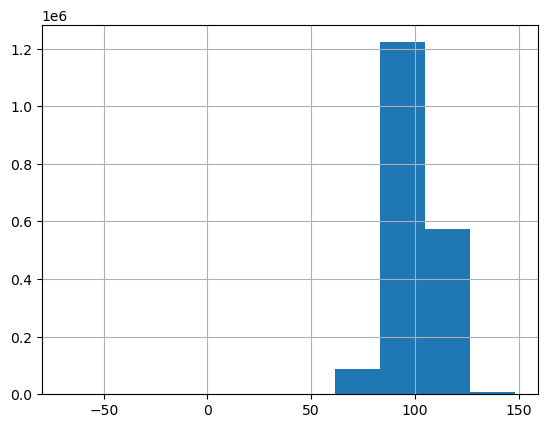

In [15]:
X['stuff+'].hist()

In [16]:
100 + (10 * (0.003394 - y_pred.mean() / y_pred.std()))

np.float64(99.1840263773893)

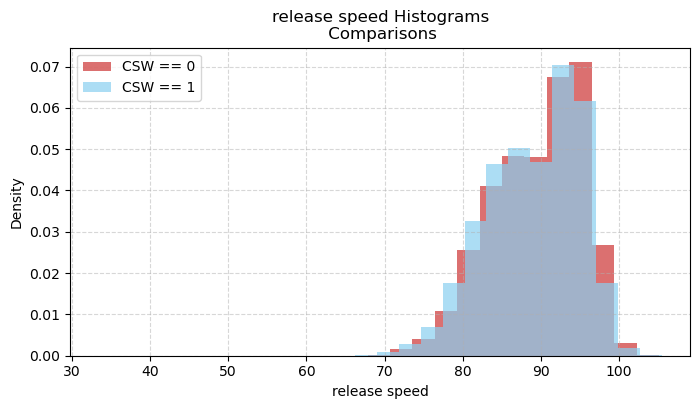

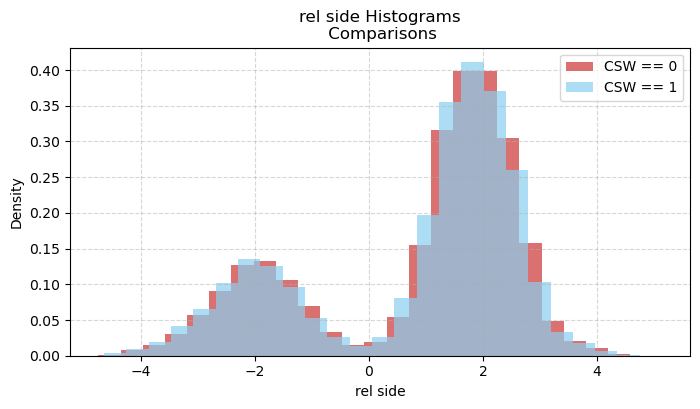

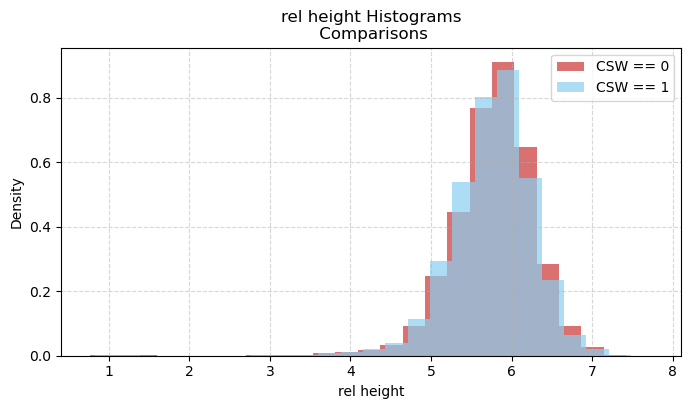

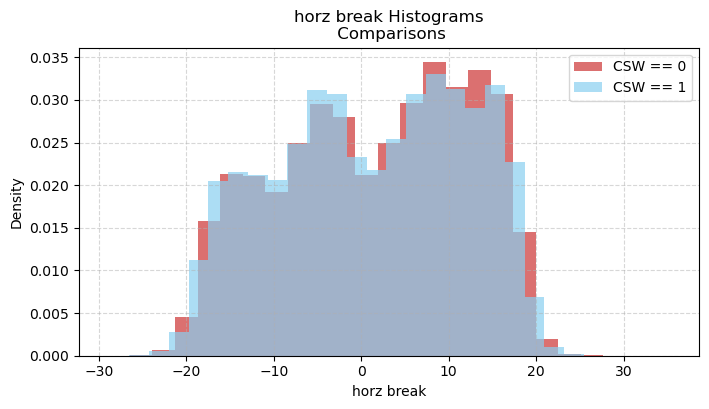

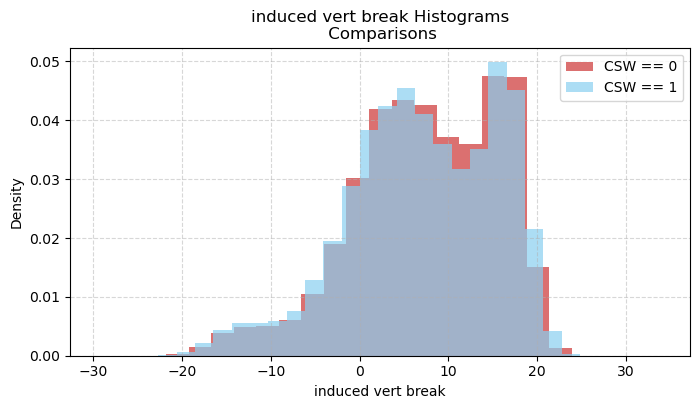

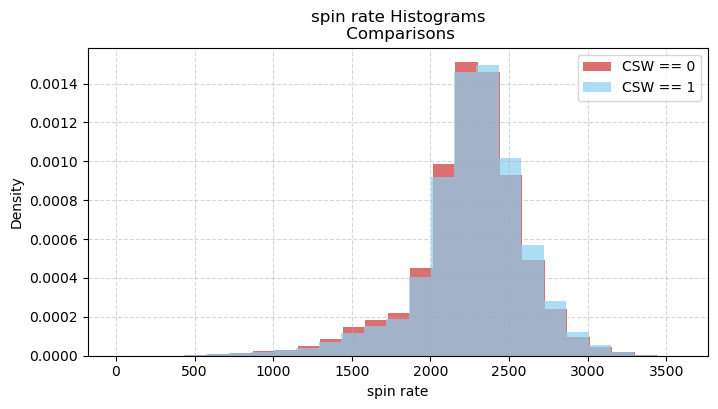

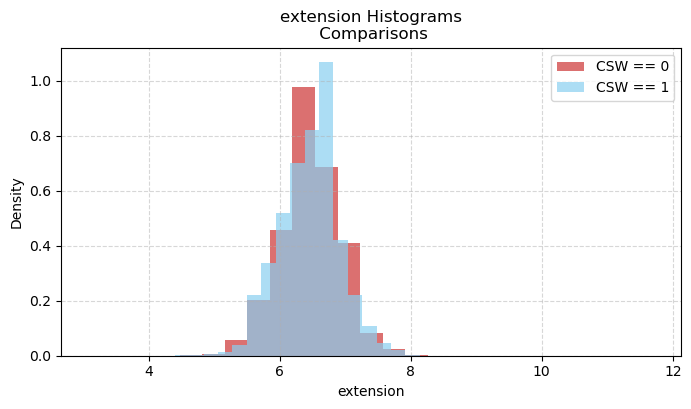

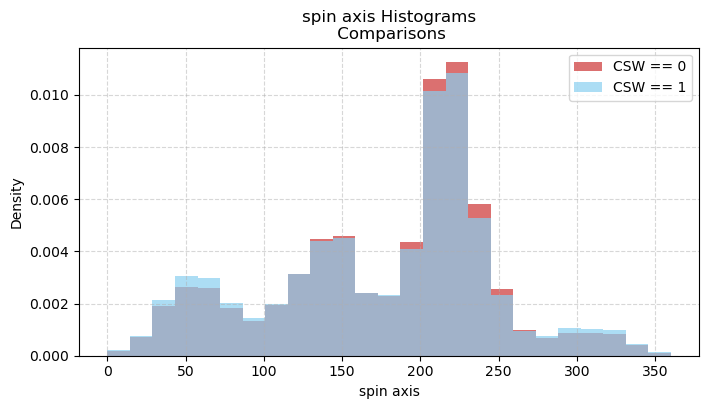

In [17]:
for i in ['release_speed', 'rel_side', 'rel_height', 'horz_break', 'induced_vert_break', 'spin_rate', 'extension', 'spin_axis']:
    catch_made_hist(statcast_data_cleaned, i)

## Result Testing

In [47]:
deep_stats = pitching_stats(2024)
deep_stats.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,BUH,K/9,BB/9,K/BB,H/9,HR/9,AVG,WHIP,BABIP,LOB%,FIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,Starting,Start-IP,Relieving,Relief-IP,RAR,Dollars,tERA,xFIP,WPA,-WPA,+WPA,RE24,REW,pLI,inLI,gmLI,exLI,Pulls,WPA/LI,Clutch,FB% 2,FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,HLD,SD,MD,ERA-,FIP-,xFIP-,K%,BB%,SIERA,RS/9,E-F,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,RA9-WAR,BIP-Wins,LOB-Wins,FDP-Wins,Age Rng,K-BB%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,kwERA,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,K/9+,BB/9+,K/BB+,H/9+,HR/9+,AVG+,WHIP+,BABIP+,LOB%+,K%+,BB%+,LD%+,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xERA,botERA,botOvr CH,botStf CH,botCmd CH,botOvr CU,botStf CU,botCmd CU,botOvr FA,botStf FA,botCmd FA,botOvr SI,botStf SI,botCmd SI,botOvr SL,botStf SL,botCmd SL,botOvr KC,botStf KC,botCmd KC,botOvr FC,botStf FC,botCmd FC,botOvr FS,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
0,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,29,0,0,0,0,177.2,702,141,48,47,9,39,0,8,4,1,225,191,143,92,8,925,1893,2818,126,5,4,0,11.40,1.98,5.77,7.14,0.46,0.215,1.01,0.314,0.798,2.09,1.34,0.216,0.448,0.336,0.056,0.063,0.026,0.000,56.2,177.2,NaN,NaN,56.2,$51.3,2.45,2.64,4.04,-9.08,13.12,41.11,4.24,0.95,0.90,0.87,0.83,29,4.37,-0.11,0.455,94.8,0.403,78.7,NaN,NaN,NaN,NaN,0.142,86.9,NaN,NaN,NaN,NaN,0.001,NaN,-5.5,24.4,NaN,NaN,12.1,NaN,NaN,-0.43,2.15,NaN,NaN,3.02,NaN,NaN,0.369,0.646,0.490,0.576,0.812,0.711,0.435,0.694,0.141,0,0,0,57,53,66,0.321,0.056,2.80,6.38,0.30,0.378,NaN,NaN,NaN,NaN,0.072,0.403,NaN,NaN,NaN,0.147,NaN,NaN,NaN,94.8,NaN,NaN,NaN,NaN,94.2,78.6,NaN,NaN,NaN,87.1,NaN,NaN,9.5,NaN,NaN,NaN,NaN,11.1,-5.3,NaN,NaN,NaN,10.1,NaN,NaN,5.8,NaN,NaN,NaN,NaN,1.6,-2.9,NaN,NaN,NaN,0.2,NaN,NaN,-1.3,NaN,NaN,NaN,NaN,-4.0,24.6,NaN,NaN,NaN,12.3,NaN,NaN,-0.12,NaN,NaN,NaN,NaN,-1.99,2.16,NaN,NaN,NaN,2.97,NaN,NaN,0.345,0.623,0.490,0.536,0.802,0.712,0.520,19.6,7.

In [48]:
deep_stats = deep_stats[['Name', 'WAR', 'ERA', 'FIP', 'xFIP', 'K%', 'BB%', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'EV', 'HardHit%', 'CSW%', 'Stuff+']].copy()
deep_stats['last_name'] = deep_stats['Name'].str.split().str[1]
deep_stats.head()

,Name,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,last_name
0,Chris Sale,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,Sale
1,Tarik Skubal,5.9,2.39,2.49,2.83,0.303,0.046,0.352,0.698,0.566,0.801,87.4,0.335,0.321,112,Skubal
2,Zack Wheeler,5.4,2.57,3.13,3.30,0.285,0.066,0.364,0.713,0.641,0.822,86.7,0.332,0.273,110,Wheeler
20,Dylan Cease,4.8,3.47,3.10,3.44,0.294,0.085,0.335,0.706,0.531,0.813,89.0,0.382,0.293,110,Cease
11,Cole Ragans,4.8,3.14,2.99,3.46,0.293,0.088,0.331,0.716,0.577,0.791,88.3,0.352,0.289,110,Ragans


In [49]:
pitch_count = statcast_data_cleaned.groupby('player_name').agg(
    total_pitches = ('pitch_name', 'count')
).reset_index()
pitch_type_count = statcast_data.groupby(['player_name', 'pitch_type']).agg(
    pitch_count = ('pitch_name', 'count')
).reset_index()

pitch_pct = pitch_type_count.merge(pitch_count, on = 'player_name', how = 'left')
pitch_pct['usage%'] = round(pitch_pct['pitch_count'] / pitch_pct['total_pitches'], 3) * 100
pitch_pct['last_name'] = pitch_pct['player_name'].str.split(',').str[0]
pitch_pct.head(8)

,player_name,pitch_type,pitch_count,total_pitches,usage%,last_name
0,"Abad, Fernando",CH,28,149.0,18.8,Abad
1,"Abad, Fernando",FF,30,149.0,20.1,Abad
2,"Abad, Fernando",KC,29,149.0,19.5,Abad
3,"Abad, Fernando",SI,91,149.0,61.1,Abad
4,"Abbott, Andrew",CH,999,5703.0,17.5,Abbott
5,"Abbott, Andrew",CU,811,5703.0,14.2,Abbott
6,"Abbott, Andrew",FC,58,5703.0,1.0,Abbott
7,"Abbott, Andrew",FF,2903,5703.0,50.9,Abbott


In [50]:
deep_stats = pd.merge(deep_stats, pitch_pct, left_on = 'last_name', right_on = 'last_name', how = 'left').copy()
deep_stats = deep_stats.drop(columns = ['Name', 'last_name']).copy()
deep_stats[deep_stats['player_name'] == 'Sale, Chris']

,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,player_name,pitch_type,pitch_count,total_pitches,usage%
0,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8
1,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",FF,2423.0,5971.0,40.6
2,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SI,362.0,5971.0,6.1
3,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,2480.0,5971.0,41.5


In [41]:
stuff_df = X[['pitcher', 'pitch_type', 'stuff+']].rename(columns={'pitcher': 'player_name'}).copy()
stuff_df[stuff_df['player_name'] == 'Crawford, Kutter']

,player_name,pitch_type,stuff+
40774,"Crawford, Kutter",FC,95.429583
40790,"Crawford, Kutter",FC,96.511989
40791,"Crawford, Kutter",FC,101.670983
40793,"Crawford, Kutter",FC,99.651379
40794,"Crawford, Kutter",FC,98.732019
...,...,...,...
1435774,"Crawford, Kutter",FC,99.509645
1435775,"Crawford, Kutter",FC,98.395596
1435776,"Crawford, Kutter",FC,101.549816
1435777,"Crawford, Kutter",FC,102.974317


In [51]:
both_stuffs = deep_stats.merge(stuff_df, on = ['player_name', 'pitch_type'], how = 'left')
both_stuffs = both_stuffs.rename(columns = {'stuff+': 'triStuff+'})
grouped_stuffs = both_stuffs.groupby(['player_name', 'pitch_type'])[['WAR', 'ERA', 'FIP', 'xFIP', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'Stuff+', 'triStuff+', 'usage%']].mean().reset_index()
grouped_stuffs.head()


,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,player_name,pitch_type,pitch_count,total_pitches,usage%,triStuff+
0,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8,115.072756
1,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8,115.195102
2,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8,112.504972
3,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8,112.915584
4,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",CH,706.0,5971.0,11.8,112.248467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,2480.0,5971.0,41.5,89.165772
5967,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,2480.0,5971.0,41.5,104.229197
5968,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,2480.0,5971.0,41.5,100.064374
5969,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,"Sale, Chris",SL,2480.0,5971.0,41.5,104.395181


,player_name,pitch_type,WAR,ERA,FIP,xFIP,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Stuff+,triStuff+,usage%
0,"Anderson, Chase",CH,1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,102.283077,26.2
1,"Anderson, Chase",CU,1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,82.777590,4.1
2,"Anderson, Chase",FC,1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,96.108393,29.3
3,"Anderson, Chase",FF,1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,89.600244,20.8
4,"Anderson, Chase",SI,1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,96.047785,8.5


In [73]:
grouped_stuffs['weighted_stuff'] = round((grouped_stuffs['usage%'] / 100) * grouped_stuffs['triStuff+'], 1)
wstuff = grouped_stuffs.groupby('player_name')[['weighted_stuff']].sum().reset_index()

#Clean final comparison dataset
compare_stuff = grouped_stuffs.merge(wstuff, on = ['player_name'], how = 'inner')
compare_stuff = compare_stuff.groupby('player_name')[['WAR', 'ERA', 'FIP', 'xFIP', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'Stuff+', 'weighted_stuff_y']].mean().reset_index().rename(columns = {'weighted_stuff_y': 'triStuff+'})
compare_stuff = compare_stuff[compare_stuff['triStuff+'] > 30]
compare_stuff

,player_name,WAR,ERA,FIP,xFIP,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Stuff+,triStuff+
0,"Anderson, Chase",1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,94.7
1,"Anderson, Drew",1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,106.2
2,"Anderson, Grant",1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,99.4
3,"Anderson, Ian",1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,94.1
4,"Anderson, Jack",1.5,3.81,4.66,4.85,0.338,0.723,0.622,0.826,98.0,89.7
...,...,...,...,...,...,...,...,...,...,...,...
100,"Valdez, Phillips",3.6,2.91,3.25,3.08,0.312,0.631,0.527,0.889,107.0,110.0
101,"Wacha, Michael",3.3,3.35,3.65,4.14,0.316,0.693,0.652,0.861,100.0,88.6
102,"Webb, Jacob",4.4,3.47,2.95,3.28,0.346,0.628,0.697,0.910,109.0,101.4
103,"Webb, Logan",4.4,3.47,2.95,3.28,0.346,0.628,0.697,0.910,109.0,99.5


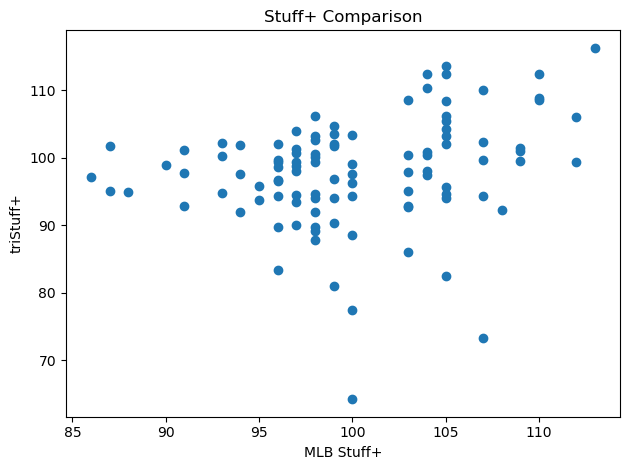

In [74]:
plt.scatter(x = compare_stuff['Stuff+'], y = compare_stuff['triStuff+'])
plt.xlabel('MLB Stuff+')
plt.ylabel('triStuff+')
plt.title('Stuff+ Comparison')
plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import r2_score

y_pred = compare_stuff.iloc[:, -1] 
y_true = compare_stuff.iloc[:, -2]

r2 = r2_score(y_pred, y_true)
print(f"R^2 Score: {r2:.3f}")

R^2 Score: -0.216


## Attempting Stuff+ based on Whiff%

In [91]:
master_trackman = pd.read_csv('../../Files/merged_trackman_games.csv')
#only pitches where the batter swung the bat
master_trackman = master_trackman[
    (master_trackman['PitchCall'] == 'InPlay') | 
    (master_trackman['PitchCall'] == 'StrikeSwinging') | 
    (master_trackman['PitchCall'] == 'FoulBallNotFieldable') | 
    (master_trackman['PitchCall'] == 'FoulBallFieldable')].copy()
master_trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.0,5320.0,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.00260,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.83690,-0.86047,0.29714,-0.13366,0.04130,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN
5,6,2025-03-25,18:10:22.73,2,5,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,2,2,Fastball,Four-Seam,InPlay,Undefined,FlyBall,Out,1,0,88.78231,-1.765824,-0.689042,1997.137307,197.112333,12:30,5.84457,0.83279,5.79238,-18.45922,17.46210,4.99000,2.66303,0.60762,80.42517,-5.273598,0.205105,0.431368,87.16723,31.673957,-6.230433,3221.122504,109.73876,60.350

In [92]:
#encode whiffs
master_trackman['whiff'] = (master_trackman['PitchCall'] == 'StrikeSwinging') * 1
master_trackman[master_trackman['whiff'] == 1]

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff
21,22,2025-03-25,18:20:33.59,4,1,"Horn, David",7.026150e+05,Right,SAN_TOR,"Bardowell, Matthew",8.052310e+05,Right,CAL_FUL,Undefined,1,Bottom,2,0,0,Fastball,Cutter,StrikeSwinging,Undefined,Undefined,Undefined,0,0,91.29270,-0.552388,-0.500070,2370.604951,189.570744,12:15,6.09845,0.27587,5.97990,-23.80887,9.96690,1.48083,3.60230,-0.06428,82.52091,-5.029428,-0.233733,0.418287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.91059,5.64540,-0.23713,50.0,6.04180,1.09071,-132.46565,-2.06903,-1.59796,31.56028,-22.26712,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,840d3df0-09e0-11f0-91ec-41cc551cf82d,90.11151,NaN,NaN,8.77179,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:20:33.59,2025-03-25T18:20:33.5956480-07:00,2025-03-26T01:20:33.5956480Z,NaN,v3,471254.0,5320.0,25 March 2025 21:00-sandiego@calstfull,"Libed, Nico",822297,Right,SAN_TOR,7f889b1d-7724-4d1b-ac86-f39226f509b4,54.51611,-133.53729,15.78014,6.09922,-1.31294,-11.13356,-0.27509,1.14497,-0.79898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,1
40,41,2025-03-25,18:33:30.61,2,2,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Meidroth, Connor",1.000115e+09,Right,SAN_TOR,Undefined,2,Top,1,0,1,Slider,Slider,StrikeSwinging,Undefined,Undefined,Undefined,0,0,77.33802,-0.018988,-0.924819,2169.072404,99.157880,9:15,5.69147,0.80132,5.57282,-43.56270,4.14201,-15.67434,2.04351,-1.36879,70.54939,-8.018062,-3.723313,0.497109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.63772,2.58847,-0.71119,50.0,5.66152,2.41240,-112.21463,-1.43316,9.63231,22.37726,-28.90959,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-G

In [225]:
feature_cols = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 'az0', 'ax0', 'VertApprAngle', 'HorzApprAngle', 'speed_diff', 'az0_diff', 'ax0_diff'] #Uses az0 and ax0 instead of IVB & HB (check tjStuff+)
target_cols = ['whiff']

## Data Cleaning

In [226]:
#Eliminate trash or NaN pitches
master_trackman = master_trackman[~(
    (master_trackman['TaggedPitchType'].isna()) | 
    (master_trackman['TaggedPitchType'] == 'Other') | 
    (master_trackman['TaggedPitchType'] == 'Knuckleball') | 
    (master_trackman['TaggedPitchType'] == 'Undefined'))]

#imputes extension and spin rate metrics
master_trackman['Extension'] = master_trackman['Extension'].fillna(master_trackman.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam'])['Extension'].transform('mean'))
master_trackman['SpinRate'] = master_trackman['SpinRate'].fillna(master_trackman.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam', 'AutoPitchType'])['SpinRate'].transform('mean'))

#Eliminate pitches with NaN features
swinging_cleaned = master_trackman.dropna(subset=feature_cols)
swinging_cleaned.head()

KeyError: ['speed_diff', 'az0_diff', 'ax0_diff']

In [227]:
#Mirror handedness

def mirror_handedness(row):
    
    # Encode 0 to LHP and 1 to RHP
    row['handedness_encode'] = int(row['PitcherThrows'] == 'Right')
    
    # Mirror if left
    if row['handedness_encode'] == 0: 
        row['HorzBreak'] *= -1
        row['RelSide'] *= -1
        row['HorzApprAngle'] *= -1
    return row

encoded_trackman = swinging_cleaned.apply(mirror_handedness, axis = 1)
encoded_trackman


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff,handedness_encode
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.0,5320.0,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.00260,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.83690,-0.86047,0.29714,-0.13366,0.04130,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,0,1
5,6,2025-03-25,18:10:22.73,2,5,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,2,2,Fastball,Four-Seam,InPlay,Undefined,FlyBall,Out,1,0,88.78231,-1.765824,-0.689042,1997.137307,197.112333,12:30,5.84457,0.83279,5.79238,-18.45922,17.46210,4.99000,2.66303,0.60762,80.42517,-5.273598,0.205105,0.431368,87.16723,31.673957,-6.230433,

In [228]:
## Finding metric differences against pitcher's avg fastball metrics

fb = encoded_trackman[(encoded_trackman['TaggedPitchType'] == 'FourSeamFastBall') | (encoded_trackman['TaggedPitchType'] == 'Fastball')]
avg_fb = fb.groupby('Pitcher').agg(
    avg_speed = ('RelSpeed', 'mean'),
    avg_vert_az = ('az0', 'mean'),
    avg_horz_ax = ('ax0', 'mean'),
    pitch_count = ('PitchNo', 'count')
    ).reset_index()
avg_fb = avg_fb[avg_fb['pitch_count'] > 2]
avg_fb = avg_fb.drop(columns = ['pitch_count']).copy()

avg_fb.head()

encoded_avg = encoded_trackman.merge(avg_fb, on = ['Pitcher'], how = 'inner')
encoded_avg['speed_diff'] = encoded_avg['RelSpeed'] - encoded_avg['avg_speed']
encoded_avg['az0_diff'] = encoded_avg['az0'] - encoded_avg['avg_vert_az']
encoded_avg['ax0_diff'] = encoded_avg['ax0'] - encoded_avg['avg_horz_ax']

encoded_avg.head()

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff,handedness_encode,avg_speed,avg_vert_az,avg_horz_ax,speed_diff,az0_diff,ax0_diff
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.0,5320.0,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.00260,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.83690,-0.86047,0.29714,-0.13366,0.04130,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,0,1,88.541247,-15.383529,-5.508783,0.320463,-2.107531,0.388833
1,6,2025-03-25,18:10:22.73,2,5,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,2,2,Fastball,Four-Seam,InPlay,Undefined,FlyBall,Out,1,0,88.78231,-1.765824,-0.689042,1997.137307,197.112333,12:30,5.84457,0.8

In [229]:
X = encoded_avg[feature_cols + target_cols]

#Cleaning more
X = X.replace({pd.NA: np.nan})
X = X.astype({col: float for col in ["RelSpeed", "SpinRate", 
                                     "ax0", "az0", 
                                     "SpinAxis", "Extension", 
                                     "RelSide", "RelHeight", "VertApprAngle"]})
X = X.dropna(subset=["RelSpeed", "SpinRate", "ax0", "az0", 
                    "SpinAxis", "Extension", "RelSide", "RelHeight", "VertApprAngle"])

X.head()

,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,az0,ax0,VertApprAngle,HorzApprAngle,speed_diff,az0_diff,ax0_diff,whiff
0,88.86171,1973.862694,199.693179,5.82053,0.88575,5.86519,-17.49106,-5.11995,-5.279977,-0.455642,0.320463,-2.107531,0.388833,0
1,88.78231,1997.137307,197.112333,5.84457,0.83279,5.79238,-15.83629,-4.60587,-5.273598,0.205105,0.241063,-0.452761,0.902913,0
2,73.60001,1953.208240,32.305517,6.12587,0.58360,5.22366,-39.14370,4.89895,-9.271858,-1.346029,-14.941237,-23.760171,10.407733,0
3,90.80199,2336.352432,174.292288,6.10209,0.79990,5.73573,-20.40375,0.86276,-5.919801,-0.336100,0.228246,-1.630093,0.103659,0
4,91.53502,2479.977991,188.119087,6.07629,0.37342,6.02602,-16.80168,-1.89699,-5.012589,0.291278,0.961276,1.971977,-2.656091,0


In [230]:
#Standardize features
y = X['whiff'].values
X = X[feature_cols].values
## potentially use robustscaler(), could be better to penalize outliers

### XGBoost Model

In [238]:
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

def run_xgb(X, y):  
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    xgb_clf = XGBClassifier(objective="binary:logistic", use_label_encoder = False, num_jobs=-1, eval_metric="logloss", tree_method="hist", random_state=42)
    
    search_spaces = {
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 12),
        "min_child_weight": Integer(1, 10),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.8, 1.0),
        "n_estimators": Integer(100, 1000),
        "gamma": Real(0.0, 5.0),
        "reg_alpha": Real(1e-8, 1.0, prior="log-uniform"),
        "reg_lambda": Real(1e-8, 1.0, prior="log-uniform"),
    }
    
    #Bayesian hyperparameter tuning
    opt = BayesSearchCV(
        estimator=xgb_clf,
        search_spaces=search_spaces,
        n_iter=30, # more iterations
        cv=3,
        scoring=make_scorer(roc_auc_score),
        random_state=42,
        n_jobs=-1,
        verbose=2
    )
    
    opt.fit(X_train, y_train)
    
    # printing best hyperparameters
    print("Best parameters found:", opt.best_params_) 
    print("Best CV AUC:", opt.best_score_)
    
    best_model = opt.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:,1]

    test_auc = roc_auc_score(y_test, y_pred_proba)
    print("Test AUC:", test_auc)
    print('Best Model:', best_model)
    
    
    # form X, y back into dataframes
    X_test = pd.DataFrame(X_test, columns=feature_cols)
    X_test["predicted_whiff_prob"] = y_pred_proba
    y_test = pd.DataFrame(y_test, columns = ['whiff'])
    
    best_model.get_booster().feature_names = feature_cols
    plot_importance(best_model, max_num_features=15)
    plt.show()
    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   0.2s
[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   0.2s
[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" }

[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   0.2s
[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   0.2s
[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   0.3s
[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   0.3s
[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   0.2s
[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   0.2s
[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=   0.4s
[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=   0.4s
[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9468056035971137, gamma=4.6968486880138585, learning_rate=0.017444866126918635, max_depth=4, m

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" }

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   0.2s
[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   0.3s
[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9086806135380625, gamma=4.600046132

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" }

[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   0.1s
[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   0.1s
[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8007260614509487, gamma=4.089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_ch

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=172, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=172, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=172, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=1, n_estimators=133, reg_alpha=0.6975719152795293, reg_lambda=1e-08, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=1, n_estimators=133, reg_alpha=0.697

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2.1345684437125167, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=665, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6781953048734859; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=2.1345684437125167, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=665, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6781953048734859; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=2.1345684437125167, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=665, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6781953048734859; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9598192522281898, gamma=0.0, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=385, reg_alpha=7.175396823918106e-08, reg_lambda=1.0, subsample=0.5; total time=   1.9s
[CV] END colsample_bytree=0.9598192522281898, gamma=0.0, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=385, reg_alpha=7.175396823918106e-08, reg_lambda=1.0, subsample=0.5; total time=   1.9s
[CV] END colsample_bytree=0.9598192522281898, gamma=0.0, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=385, reg_alpha=7.175396823918106e-08, reg_lambda=1.0, subsample=0.5; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9806867078235921, gamma=0.0, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=2, n_estimators=595, reg_alpha=2.059157464690331e-06, reg_lambda=1.0, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9806867078235921, gamma=0.0, learning_rate=0.299999

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9806867078235921, gamma=0.0, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=2, n_estimators=595, reg_alpha=2.059157464690331e-06, reg_lambda=1.0, subsample=1.0; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8239236191586173, gamma=0.8431496505065699, learning_rate=0.10461658441816371, max_depth=12, min_child_weight=2, n_estimators=933, reg_alpha=0.002880453190609349, reg_lambda=1.0, subsample=0.6624911712383226; total time=   0.6s
[CV] END colsample_bytree=0.8239236191586173, gamma=0.8431496505065699, learning_rate=0.10461658441816371, max_depth=12, min_child_weight=2, n_estimators=933, reg_alpha=0.002880453190609349, reg_lambda=1.0, subsample=0.6624911712383226; total time=   0.6s
[CV] END colsample_bytree=0.8239236191586173, gamma=0.8431496505065699, learning_rate=0.10461658441816371, max_depth=12, min_child_weight=2, n_estimators=933, reg_alpha=0.002880453190609349, reg_lambda=1.0, subsample=0.6624911712383226; total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8, gamma=5.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0, subsample=1

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.936790649989233, gamma=0.5498677063721323, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=8, n_estimators=345, reg_alpha=5.0702809738977685e-08, reg_lambda=1e-08, subsample=0.8306149132298436; total time=   0.3s
[CV] END colsample_bytree=0.936790649989233, gamma=0.5498677063721323, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=8, n_estimators=345, reg_alpha=5.0702809738977685e-08, reg_lambda=1e-08, subsample=0.8306149132298436; total time=   0.3s
[CV] END colsample_bytree=0.936790649989233, gamma=0.5498677063721323, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=8, n_estimators=345, reg_alpha=5.0702809738977685e-08, reg_lambda=1e-08, subsample=0.8306149132298436; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=1.4314005552315585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=848, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=1.4314005552315585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=848, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=1.4314005552315585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=848, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.7784911014500451; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.7784911014500451; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=10, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.7784911014500451; total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.806777457236585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6954065684772612; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.806777457236585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6954065684772612; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.806777457236585, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.6954065684772612; total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8391163228740162, gamma=0.0, learning_rate=0.04488475901043856, max_depth=12, min_child_weight=1, n_estimators=857, reg_alpha=1e-08, reg_lambda=1e-08, subsample=0.8022838752484163; total time=   1.9s
[CV] END colsample_bytree=0.8391163228740162, gamma=0.0, learning_rate=0.04488475901043856, max_depth=12, min_child_weight=1, n_estimators=857, reg_alpha=1e-08, reg_lambda=1e-08, subsample=0.8022838752484163; total time=   1.9s
[CV] END colsample_bytree=0.8391163228740162, gamma=0.0, learning_rate=0.04488475901043856, max_depth=12, min_child_weight=1, n_estimators=857, reg_alpha=1e-08, reg_lambda=1e-08, subsample=0.8022838752484163; total time=   2.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8473706413203753, gamma=4.807274640709269, learning_rate=0.21441026764139096, max_depth=3, min_child_weight=3, n_estimators=425, reg_alpha=0.00019495847793649473, reg_lambda=2.9714322400631758e-08, subsample=0.5051546016125044; t

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1847515642746841, max_depth=12, min_child_weight=3, n_estimators=239, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.6991092521647695; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1847515642746841, max_depth=12, min_child_weight=3, n_estimators=239, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.6991092521647695; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1847515642746841, max_depth=12, min_child_weight=3, n_estimators=239, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.6991092521647695; total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=4, n_estimators=209, reg_alpha=0.11135824627398298, reg_lambda=9.760168922279052e-08, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=4, n_es

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=904, reg_alpha=0.0004136887388300117, reg_lambda=1.0, subsample=0.8410649547090148; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=904, reg_alpha=0.0004136887388300117, reg_lambda=1.0, subsample=0.8410649547090148; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=904, reg_alpha=0.0004136887388300117, reg_lambda=1.0, subsample=0.8410649547090148; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=901, reg_alpha=0.0005812888932470644, reg_lambda=1.0, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=901, reg_alpha=0.0005812888932470644, reg_lambda=1.0, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=1, n_estimators=901, reg_alpha=0.0005812888932470644, reg_lambda=1.0, subsample=1.0; total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=3.0623540590445986, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=983, reg_alpha=0.055195559202102236, reg_lambda=0.00010129241199354915, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=3.0623540590445986, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=983, reg_alpha=0.055195559202102236, reg_lambda=0.00010129241199354915, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=3.0623540590445986, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=983, reg_alpha=0.055195559202102236, reg_lambda=0.00010129241199354915, subsample=0.5; total time=   1.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8327687204304737, gamma=2.650432864201629, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=8, n_estimators=105, reg_alpha=2.156727671687801e-05, reg_lambda=1.707403407082449e-06, subsample=0.566050563751310

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1.0, gamma=2.6794655159621255, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.2s


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_jobs", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2.6794655159621255, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=2.6794655159621255, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=100, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=   0.2s
Best parameters found: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.1847515642746841), ('max_depth', 12), ('min_child_weight', 3), ('n_estimators', 239), ('reg_alpha', 1.0), ('reg_lambda', 1e-08), ('subsample', 0.6991092521647695)])
Best CV AUC: 0.6345776673430404
Test AUC: 0.7544097720683324
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval

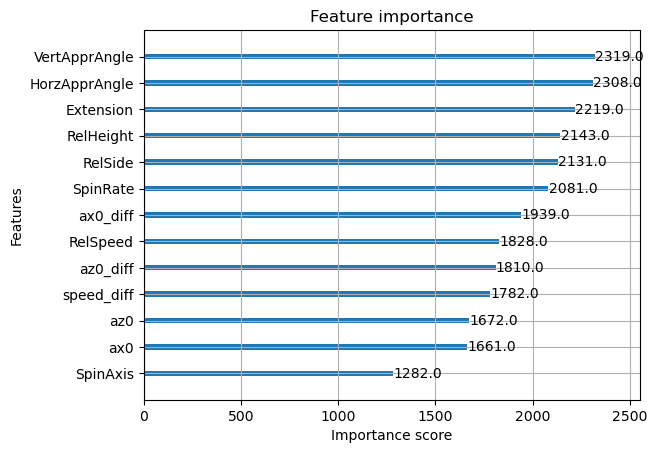

In [239]:
run_xgb(X, y)

### Feature Importance

In [170]:
predicted_whiff['whiff'] = whiffs
predicted_whiff

,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,az0,ax0,VertApprAngle,HorzApprAngle,predicted_whiff_prob,whiff
0,94.76908,2054.666316,187.663326,6.58741,1.41835,6.10005,-15.70377,-2.91250,-6.257903,-1.702339,0.003798,0
1,77.04746,2868.804570,248.314895,5.03137,1.95831,5.20224,-27.43129,-8.56409,-5.907286,-5.041131,0.462613,0
2,90.84200,2413.202573,228.299244,5.13286,2.23446,6.65020,-19.36935,-12.60358,-6.582067,-0.907124,0.099879,0
3,84.50938,2378.321498,127.962083,5.57145,1.17450,5.03305,-25.90828,6.04862,-5.188082,-2.498319,0.453247,0
4,89.79155,2296.749939,194.111190,5.97147,1.26139,5.07780,-11.84142,-5.33372,-4.507949,-0.799181,0.070422,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,83.85551,2581.698121,103.561210,5.04039,2.79128,6.00844,-27.53252,10.62969,-6.436575,-5.154407,0.766685,0
3037,91.58437,2464.912399,210.825633,6.34945,1.92491,6.11054,-6.87778,-14.71757,-5.860413,-1.144826,0.017383,0
3038,78.79286,1885.341750,247.572998,5.63700,1.36819,5.84500,-26.89729,-9.58101,-7.731624,-0.575615,0.137527,0
3039,85.22995,2501.308688,161.876578,5.45061,1.93470,5.39148,-23.93747,3.31121,-5.958684,-2.183210,0.012702,0


In [163]:
whiffs

,whiff
0,0
1,0
2,0
3,0
4,0
...,...
3036,0
3037,0
3038,0
3039,0


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,az0,ax0,VertApprAngle,HorzApprAngle,predicted_whiff_prob,whiff
0,94.76908,2054.666316,187.663326,6.58741,1.41835,6.10005,-15.70377,-2.91250,-6.257903,-1.702339,0.032690,NaN
1,77.04746,2868.804570,248.314895,5.03137,1.95831,5.20224,-27.43129,-8.56409,-5.907286,-5.041131,0.633541,NaN
2,90.84200,2413.202573,228.299244,5.13286,2.23446,6.65020,-19.36935,-12.60358,-6.582067,-0.907124,0.012277,NaN
3,84.50938,2378.321498,127.962083,5.57145,1.17450,5.03305,-25.90828,6.04862,-5.188082,-2.498319,0.441911,NaN
4,89.79155,2296.749939,194.111190,5.97147,1.26139,5.07780,-11.84142,-5.33372,-4.507949,-0.799181,0.128040,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
